# Collaboration and Competition

---

This notebook presents a a multi agent DDPG approach for solving the Tennis environment

### 1. Start the Environment

Please install all dependencies as explained in the Getting Started section in the README.MD

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [1]:
FILENAME="C:\\Users\\marti\\Desktop\\drl\\p3_collab-compet\\Tennis_Windows_x86_64\Tennis.exe"

### 2. Import libaries


In [2]:
from unityagents import UnityEnvironment
import numpy as np
from itertools import count
from collections import namedtuple, deque
import random
import copy
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


Load the environment

In [3]:
env = UnityEnvironment(file_name=FILENAME)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


#### Check the environment

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training or trained?

If you want to run the training algorithm continue with the cells below. Otherwise jump to step 4 at the bottom of the notebook.

#### Set the Hyperparameters

In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1024       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### The Algorithm
The algorithm is based on an DDGP Approach and conists of three main parts:

* An actor network for creating a distribution of actions (2 hidden layers)
* A critic network to estimate the state Value function (2 hidden layers)
* An agent class which brings both networks together

#### The Actor class
This is a simple deep neural network to estimate the distribution of actions, based on a given input state. The tanh function at the end compresses the outputs to the interval [-1 ... 1] which are used later in the Reacher environment.


In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
            
    def reset_parameters(self):
        
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))




#### The Critic Class

Like the Actor class it is a straight forward deep neural network. 

In [7]:
# The 
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):

        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


#### Replay Buffer and target networks
Similar to the DQN approach the replay buffer stores the experience tuples to train actor and critic network. Target networks are used to decouple the parameters during the learning phase and the target one would like to optimize.

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### The Agent 
The Agent class contains the following function

* init: Initialize the actor and critic networks (local and target) and the Replay Buffer. In total four networks are created.
* step: The agent stores the results of the action, such as reward, new_state etc in the ReplayBuffer. If enough examples are stored in the ReplayBuffer it uses them to conduct a batch learning process.
* act: Using the local actor network the next action is pedicted
* learn: Optimizes the local network using backpropagation (AdamOptimizer), but takes the targets from the target network. The key element here is that:


+ 1. The distribution of actions is taken from the actor target networks 
+ 2. The distribution and state space together are used to calculate the target of the critic network
+ 3. The critic network (local) is trained on its targets
+ 4. The result of the training process is used to calculate the actor loss (how bad/good the estimate is) to train the actor network


* soft_update: Copies parameters from the local to the target network

In [9]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed=42):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

           
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()

        return np.clip(action, -1, 1)
    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [10]:
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=42)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=42)

### 3. Training or trained?

If you want to run the training algorithm continue with the cells below. Otherwise jump to step 4 at the bottom of the notebook.

In [11]:
def ddpg(n_episodes=2000, max_runs=1500):
    solved = False
    scores_window = deque(maxlen=50)
    scores = []
    score  = 0
    max_score = -1
    actions = np.zeros([num_agents, action_size])
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]      
        states = env_info.vector_observations                 
        scores_agents = np.zeros(num_agents)  
        score = 0
        start = time.time()
        
        for t in range(max_runs):

            actions = np.random.randn(num_agents, action_size)
            actions[0] = agent1.act(states[0])                 
            actions[1] = agent2.act(states[1])
  
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                        
            dones = env_info.local_done                        
           
            agent1.step(states, actions, rewards, next_states, dones)
            agent2.step(states, actions, rewards, next_states, dones)
 
            states = next_states                               
            scores_agents += rewards
            
            if np.any(dones):
                break 
 
        score = scores_agents.max()
        scores_window.append(score)
        scores.append(score)
        
        print('\rEpisode {}\t Average Score: {:.2f}\t Score: {:.2f}'.format(i_episode, np.mean(scores_window), score), end="")
        print(' Elapsed time: ', (time.time() - start))
        
        if i_episode % 50 == 0:
            print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)))  
        
        if (not solved) and (np.mean(scores_window) >= 0.50) :
            solved = True
            print('\nEnvironment solved in {:d} episodes!\t Average Score: {:5.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent1.actor_local.state_dict(), 'save_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'save_critic1.pth')
            torch.save(agent2.actor_local.state_dict(), 'save_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), 'save_critic2.pth')
            
           
    return scores

In [12]:
scores = ddpg(n_episodes=2000,max_runs=1500) 
plt.show()

Episode 1	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.3819658756256104
Episode 2	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.08078289031982422
Episode 3	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.07640814781188965
Episode 4	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.11739230155944824
Episode 5	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.06782007217407227
Episode 6	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.12366938591003418
Episode 7	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.14126992225646973
Episode 8	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.08875465393066406
Episode 9	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.15154480934143066
Episode 10	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.13663101196289062
Episode 11	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.14151763916015625
Episode 12	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.1037437915802002
Episode 13	 Average Score: 0.00	 Score: 0.00 Elapse

c:\users\marti\anaconda3\envs\drl\lib\site-packages\ipykernel_launcher.py:80: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 25	 Average Score: 0.00	 Score: 0.09 Elapsed time:  0.6234450340270996
Episode 26	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.097163200378418
Episode 27	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.1266624927520752
Episode 28	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.102215051651001
Episode 29	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.113368272781372
Episode 30	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7779355049133301
Episode 31	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8324265480041504
Episode 32	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8170030117034912
Episode 33	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8508038520812988
Episode 34	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.883030891418457
Episode 35	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.93056321144104
Episode 36	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8226597309112549
Episode 37	 Average Score: 0.00	 Score: 0.00 Elapsed time:

Episode 128	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8120224475860596
Episode 129	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.800187349319458
Episode 130	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7938926219940186
Episode 131	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8644630908966064
Episode 132	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.9106128215789795
Episode 133	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.0895731449127197
Episode 134	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.061244249343872
Episode 135	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7980430126190186
Episode 136	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8450090885162354
Episode 137	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.1257944107055664
Episode 138	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.0284957885742188
Episode 139	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8937468528747559
Episode 140	 Average Score: 0.00	 Score: 0

Episode 230	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8912882804870605
Episode 231	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8776888847351074
Episode 232	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8935167789459229
Episode 233	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8193957805633545
Episode 234	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7879211902618408
Episode 235	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7769508361816406
Episode 236	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.823932409286499
Episode 237	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8316793441772461
Episode 238	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8702175617218018
Episode 239	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.818310022354126
Episode 240	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.799879789352417
Episode 241	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7910850048065186
Episode 242	 Average Score: 0.00	 Score: 0.

Episode 332	 Average Score: 0.00	 Score: 0.00 Elapsed time:  1.0319805145263672
Episode 333	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8030843734741211
Episode 334	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8079712390899658
Episode 335	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7979974746704102
Episode 336	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8109045028686523
Episode 337	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8559601306915283
Episode 338	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7970967292785645
Episode 339	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.764552116394043
Episode 340	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8059637546539307
Episode 341	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8130624294281006
Episode 342	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8897843360900879
Episode 343	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7737367153167725
Episode 344	 Average Score: 0.00	 Score: 

Episode 434	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8477377891540527
Episode 435	 Average Score: 0.00	 Score: 0.09 Elapsed time:  2.033717155456543
Episode 436	 Average Score: 0.00	 Score: 0.09 Elapsed time:  1.7382421493530273
Episode 437	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7869789600372314
Episode 438	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8259434700012207
Episode 439	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8113677501678467
Episode 440	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8382854461669922
Episode 441	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8612155914306641
Episode 442	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8467600345611572
Episode 443	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8903002738952637
Episode 444	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8288300037384033
Episode 445	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8558292388916016
Episode 446	 Average Score: 0.00	 Score: 

Episode 536	 Average Score: 0.01	 Score: 0.00 Elapsed time:  0.8283724784851074
Episode 537	 Average Score: 0.01	 Score: 0.00 Elapsed time:  0.845346212387085
Episode 538	 Average Score: 0.01	 Score: 0.09 Elapsed time:  1.8183197975158691
Episode 539	 Average Score: 0.01	 Score: 0.10 Elapsed time:  1.7723135948181152
Episode 540	 Average Score: 0.01	 Score: 0.09 Elapsed time:  1.898956298828125
Episode 541	 Average Score: 0.02	 Score: 0.10 Elapsed time:  1.713423252105713
Episode 542	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.806257963180542
Episode 543	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8088555335998535
Episode 544	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8269176483154297
Episode 545	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8587567806243896
Episode 546	 Average Score: 0.02	 Score: 0.09 Elapsed time:  1.7682600021362305
Episode 547	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8746752738952637
Episode 548	 Average Score: 0.02	 Score: 0.0

Episode 638	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.9174008369445801
Episode 639	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8632297515869141
Episode 640	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7944443225860596
Episode 641	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8163647651672363
Episode 642	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8078114986419678
Episode 643	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8712911605834961
Episode 644	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8182873725891113
Episode 645	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8019881248474121
Episode 646	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8224813938140869
Episode 647	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.7934460639953613
Episode 648	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.909337043762207
Episode 649	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.9055771827697754
Episode 650	 Average Score: 0.00	 Score: 

Episode 740	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8656919002532959
Episode 741	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.797919511795044
Episode 742	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.828967809677124
Episode 743	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8113977909088135
Episode 744	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8018417358398438
Episode 745	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.9186322689056396
Episode 746	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8840303421020508
Episode 747	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8019709587097168
Episode 748	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8258132934570312
Episode 749	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8130428791046143
Episode 750	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8443410396575928
Episode 750	 Average Score: 0.00
Episode 751	 Average Score: 0.00	 Score: 0.00 Elapsed time:  0.8145401477813721
Episode 7

Episode 842	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.813645601272583
Episode 843	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8164057731628418
Episode 844	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8158111572265625
Episode 845	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8243918418884277
Episode 846	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8318257331848145
Episode 847	 Average Score: 0.02	 Score: 0.10 Elapsed time:  3.1613500118255615
Episode 848	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8095192909240723
Episode 849	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8148252964019775
Episode 850	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.7769346237182617
Episode 850	 Average Score: 0.02
Episode 851	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8179197311401367
Episode 852	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8389153480529785
Episode 853	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8134150505065918
Episode 

Episode 944	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8492436408996582
Episode 945	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.7190823554992676
Episode 946	 Average Score: 0.03	 Score: 0.09 Elapsed time:  1.7078912258148193
Episode 947	 Average Score: 0.03	 Score: 0.10 Elapsed time:  1.506542444229126
Episode 948	 Average Score: 0.03	 Score: 0.09 Elapsed time:  1.8072113990783691
Episode 949	 Average Score: 0.03	 Score: 0.10 Elapsed time:  1.5610792636871338
Episode 950	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8237848281860352
Episode 950	 Average Score: 0.03
Episode 951	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.7465167045593262
Episode 952	 Average Score: 0.04	 Score: 0.10 Elapsed time:  1.5270264148712158
Episode 953	 Average Score: 0.04	 Score: 0.00 Elapsed time:  0.813361406326294
Episode 954	 Average Score: 0.04	 Score: 0.00 Elapsed time:  0.8865625858306885
Episode 955	 Average Score: 0.04	 Score: 0.00 Elapsed time:  0.8178131580352783
Episode 9

Episode 1046	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.7909290790557861
Episode 1047	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8116888999938965
Episode 1048	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8761711120605469
Episode 1049	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8836884498596191
Episode 1050	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.7988882064819336
Episode 1050	 Average Score: 0.03
Episode 1051	 Average Score: 0.02	 Score: 0.00 Elapsed time:  0.8262794017791748
Episode 1052	 Average Score: 0.03	 Score: 0.09 Elapsed time:  1.7402379512786865
Episode 1053	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8318500518798828
Episode 1054	 Average Score: 0.03	 Score: 0.10 Elapsed time:  1.9304320812225342
Episode 1055	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.8134481906890869
Episode 1056	 Average Score: 0.03	 Score: 0.00 Elapsed time:  0.7860548496246338
Episode 1057	 Average Score: 0.03	 Score: 0.10 Elapsed time:  1.92508268356

Episode 1147	 Average Score: 0.05	 Score: 0.00 Elapsed time:  0.814406156539917
Episode 1148	 Average Score: 0.05	 Score: 0.09 Elapsed time:  1.7296361923217773
Episode 1149	 Average Score: 0.05	 Score: 0.00 Elapsed time:  0.8700807094573975
Episode 1150	 Average Score: 0.05	 Score: 0.09 Elapsed time:  1.7289297580718994
Episode 1150	 Average Score: 0.05
Episode 1151	 Average Score: 0.05	 Score: 0.00 Elapsed time:  0.869574785232544
Episode 1152	 Average Score: 0.05	 Score: 0.20 Elapsed time:  4.1557793617248535
Episode 1153	 Average Score: 0.05	 Score: 0.00 Elapsed time:  0.8867061138153076
Episode 1154	 Average Score: 0.05	 Score: 0.00 Elapsed time:  0.8617727756500244
Episode 1155	 Average Score: 0.04	 Score: 0.00 Elapsed time:  0.8786747455596924
Episode 1156	 Average Score: 0.05	 Score: 0.09 Elapsed time:  1.7662696838378906
Episode 1157	 Average Score: 0.05	 Score: 0.09 Elapsed time:  1.8295941352844238
Episode 1158	 Average Score: 0.05	 Score: 0.00 Elapsed time:  0.8292891979217

Episode 1248	 Average Score: 0.06	 Score: 0.09 Elapsed time:  1.8250932693481445
Episode 1249	 Average Score: 0.06	 Score: 0.10 Elapsed time:  1.8302674293518066
Episode 1250	 Average Score: 0.06	 Score: 0.09 Elapsed time:  1.8094210624694824
Episode 1250	 Average Score: 0.06
Episode 1251	 Average Score: 0.06	 Score: 0.09 Elapsed time:  1.74102783203125
Episode 1252	 Average Score: 0.06	 Score: 0.09 Elapsed time:  1.8909432888031006
Episode 1253	 Average Score: 0.06	 Score: 0.09 Elapsed time:  1.8850674629211426
Episode 1254	 Average Score: 0.06	 Score: 0.00 Elapsed time:  1.1252079010009766
Episode 1255	 Average Score: 0.06	 Score: 0.10 Elapsed time:  1.7157623767852783
Episode 1256	 Average Score: 0.06	 Score: 0.10 Elapsed time:  1.7396306991577148
Episode 1257	 Average Score: 0.06	 Score: 0.10 Elapsed time:  1.8132438659667969
Episode 1258	 Average Score: 0.06	 Score: 0.10 Elapsed time:  1.5594427585601807
Episode 1259	 Average Score: 0.07	 Score: 0.20 Elapsed time:  5.1358733177185

Episode 1349	 Average Score: 0.14	 Score: 0.10 Elapsed time:  1.8102586269378662
Episode 1350	 Average Score: 0.14	 Score: 0.30 Elapsed time:  6.4750378131866455
Episode 1350	 Average Score: 0.14
Episode 1351	 Average Score: 0.14	 Score: 0.20 Elapsed time:  5.0733232498168945
Episode 1352	 Average Score: 0.14	 Score: 0.20 Elapsed time:  5.755114316940308
Episode 1353	 Average Score: 0.15	 Score: 0.59 Elapsed time:  13.211153984069824
Episode 1354	 Average Score: 0.16	 Score: 0.30 Elapsed time:  7.778286457061768
Episode 1355	 Average Score: 0.16	 Score: 0.19 Elapsed time:  4.082199335098267
Episode 1356	 Average Score: 0.16	 Score: 0.30 Elapsed time:  8.711775779724121
Episode 1357	 Average Score: 0.17	 Score: 0.20 Elapsed time:  5.897952079772949
Episode 1358	 Average Score: 0.17	 Score: 0.30 Elapsed time:  7.058174133300781
Episode 1359	 Average Score: 0.17	 Score: 0.30 Elapsed time:  7.395815134048462
Episode 1360	 Average Score: 0.17	 Score: 0.20 Elapsed time:  4.075717210769653
Ep

Episode 1450	 Average Score: 0.55	 Score: 1.90 Elapsed time:  50.898149728775024
Episode 1450	 Average Score: 0.55
Episode 1451	 Average Score: 0.56	 Score: 0.50 Elapsed time:  12.06116247177124
Episode 1452	 Average Score: 0.56	 Score: 0.10 Elapsed time:  3.1879770755767822
Episode 1453	 Average Score: 0.56	 Score: 0.40 Elapsed time:  11.233307600021362
Episode 1454	 Average Score: 0.61	 Score: 2.60 Elapsed time:  62.2680926322937
Episode 1455	 Average Score: 0.62	 Score: 1.10 Elapsed time:  28.285651922225952
Episode 1456	 Average Score: 0.63	 Score: 0.70 Elapsed time:  14.803130626678467
Episode 1457	 Average Score: 0.68	 Score: 2.50 Elapsed time:  61.557730197906494
Episode 1458	 Average Score: 0.70	 Score: 1.40 Elapsed time:  33.33553123474121
Episode 1459	 Average Score: 0.69	 Score: 0.10 Elapsed time:  3.057657241821289
Episode 1460	 Average Score: 0.70	 Score: 0.90 Elapsed time:  21.161226511001587
Episode 1461	 Average Score: 0.73	 Score: 2.49 Elapsed time:  58.8999183177948
E

Episode 1551	 Average Score: 0.94	 Score: 1.30 Elapsed time:  33.2688307762146
Episode 1552	 Average Score: 0.99	 Score: 2.60 Elapsed time:  66.64320969581604
Episode 1553	 Average Score: 0.99	 Score: 0.10 Elapsed time:  2.320366859436035
Episode 1554	 Average Score: 1.03	 Score: 2.60 Elapsed time:  66.54239177703857
Episode 1555	 Average Score: 1.07	 Score: 2.10 Elapsed time:  51.313427448272705
Episode 1556	 Average Score: 1.11	 Score: 2.60 Elapsed time:  66.84606885910034
Episode 1557	 Average Score: 1.15	 Score: 2.60 Elapsed time:  67.67028403282166
Episode 1558	 Average Score: 1.15	 Score: 0.09 Elapsed time:  0.3705906867980957
Episode 1559	 Average Score: 1.15	 Score: 0.10 Elapsed time:  4.590921878814697
Episode 1560	 Average Score: 1.17	 Score: 1.30 Elapsed time:  35.62791180610657
Episode 1561	 Average Score: 1.17	 Score: 0.20 Elapsed time:  4.804452657699585
Episode 1562	 Average Score: 1.17	 Score: 0.20 Elapsed time:  8.143479585647583
Episode 1563	 Average Score: 1.17	 Scor

Episode 1653	 Average Score: 1.32	 Score: 1.00 Elapsed time:  28.0227370262146
Episode 1654	 Average Score: 1.33	 Score: 2.60 Elapsed time:  75.61795353889465
Episode 1655	 Average Score: 1.28	 Score: 0.20 Elapsed time:  5.918442964553833
Episode 1656	 Average Score: 1.28	 Score: 2.60 Elapsed time:  74.36047863960266
Episode 1657	 Average Score: 1.28	 Score: 2.70 Elapsed time:  74.41304326057434
Episode 1658	 Average Score: 1.26	 Score: 0.40 Elapsed time:  12.140119552612305
Episode 1659	 Average Score: 1.30	 Score: 2.60 Elapsed time:  74.57688212394714
Episode 1660	 Average Score: 1.31	 Score: 0.70 Elapsed time:  20.906445741653442
Episode 1661	 Average Score: 1.36	 Score: 2.60 Elapsed time:  77.67153215408325
Episode 1662	 Average Score: 1.37	 Score: 2.70 Elapsed time:  79.18019437789917
Episode 1663	 Average Score: 1.39	 Score: 1.80 Elapsed time:  52.68168497085571
Episode 1664	 Average Score: 1.39	 Score: 0.50 Elapsed time:  14.000462532043457
Episode 1665	 Average Score: 1.39	 Sco

Episode 1755	 Average Score: 1.59	 Score: 0.30 Elapsed time:  11.003031492233276
Episode 1756	 Average Score: 1.55	 Score: 0.80 Elapsed time:  27.64896249771118
Episode 1757	 Average Score: 1.55	 Score: 0.10 Elapsed time:  2.7034010887145996
Episode 1758	 Average Score: 1.54	 Score: 0.10 Elapsed time:  2.6234610080718994
Episode 1759	 Average Score: 1.54	 Score: 0.30 Elapsed time:  11.031612873077393
Episode 1760	 Average Score: 1.52	 Score: 0.20 Elapsed time:  4.337049245834351
Episode 1761	 Average Score: 1.52	 Score: 0.10 Elapsed time:  2.647244453430176
Episode 1762	 Average Score: 1.53	 Score: 0.20 Elapsed time:  9.312553644180298
Episode 1763	 Average Score: 1.51	 Score: 0.10 Elapsed time:  4.416100978851318
Episode 1764	 Average Score: 1.46	 Score: 0.30 Elapsed time:  11.504839420318604
Episode 1765	 Average Score: 1.47	 Score: 0.40 Elapsed time:  14.503151655197144
Episode 1766	 Average Score: 1.42	 Score: 0.19 Elapsed time:  5.7401344776153564
Episode 1767	 Average Score: 1.42

Episode 1857	 Average Score: 0.21	 Score: 0.30 Elapsed time:  12.226532936096191
Episode 1858	 Average Score: 0.22	 Score: 0.40 Elapsed time:  15.018139839172363
Episode 1859	 Average Score: 0.22	 Score: 0.20 Elapsed time:  6.993935823440552
Episode 1860	 Average Score: 0.22	 Score: 0.20 Elapsed time:  8.509966373443604
Episode 1861	 Average Score: 0.21	 Score: 0.10 Elapsed time:  5.902496337890625
Episode 1862	 Average Score: 0.21	 Score: 0.10 Elapsed time:  2.993594169616699
Episode 1863	 Average Score: 0.21	 Score: 0.10 Elapsed time:  6.181368112564087
Episode 1864	 Average Score: 0.22	 Score: 0.40 Elapsed time:  14.919211149215698
Episode 1865	 Average Score: 0.22	 Score: 0.30 Elapsed time:  14.770121812820435
Episode 1866	 Average Score: 0.21	 Score: 0.10 Elapsed time:  5.948490381240845
Episode 1867	 Average Score: 0.22	 Score: 0.40 Elapsed time:  16.12800431251526
Episode 1868	 Average Score: 0.21	 Score: 0.10 Elapsed time:  2.8850815296173096
Episode 1869	 Average Score: 0.21	 

Episode 1959	 Average Score: 1.53	 Score: 2.40 Elapsed time:  101.60700750350952
Episode 1960	 Average Score: 1.50	 Score: 1.00 Elapsed time:  41.732908964157104
Episode 1961	 Average Score: 1.50	 Score: 2.60 Elapsed time:  105.88427472114563
Episode 1962	 Average Score: 1.50	 Score: 2.60 Elapsed time:  106.13973069190979
Episode 1963	 Average Score: 1.53	 Score: 2.70 Elapsed time:  107.24192667007446
Episode 1964	 Average Score: 1.51	 Score: 1.60 Elapsed time:  66.48588919639587
Episode 1965	 Average Score: 1.52	 Score: 0.60 Elapsed time:  25.225727558135986
Episode 1966	 Average Score: 1.55	 Score: 1.40 Elapsed time:  62.83316993713379
Episode 1967	 Average Score: 1.57	 Score: 2.09 Elapsed time:  95.42546510696411
Episode 1968	 Average Score: 1.58	 Score: 1.30 Elapsed time:  62.11931085586548
Episode 1969	 Average Score: 1.58	 Score: 2.60 Elapsed time:  119.07125663757324
Episode 1970	 Average Score: 1.55	 Score: 0.70 Elapsed time:  34.107648611068726
Episode 1971	 Average Score: 1.5

#### The environment is solved in 1446 episodes with an average score > 0.5 for more than 100 consecutive episodes

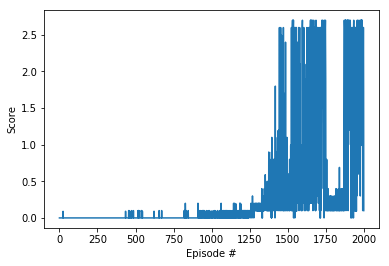

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Run a trained agent

In [14]:
agent1.actor_local.load_state_dict(torch.load('save_actor1.pth'))
agent1.critic_local.load_state_dict(torch.load('save_critic1.pth'))
agent2.actor_local.load_state_dict(torch.load('save_actor2.pth'))
agent2.critic_local.load_state_dict(torch.load('save_critic2.pth'))

scores=[]
for i in range(2): 
    env_info = env.reset(train_mode=False)[brain_name] 
    states = env_info.vector_observations    
    scores_agents = np.zeros(num_agents)
    score = 0                                          
    while True:
        
        actions = np.random.randn(num_agents, action_size)
        actions[0] = agent1.act(states[0])                 
        actions[1] = agent2.act(states[1])
                      
        env_info = env.step(actions)[brain_name]       
        
        next_states = env_info.vector_observations
        rewards = env_info.rewards                   
        dones = env_info.local_done    
        
        scores_agents += rewards                                
        states = next_states                             
        if np.any(dones):                                       
            break
    
    score = scores_agents.max()
    scores.append(score)
    print("Episode : {:2d} Score : {:5.2f}".format(i+1,score))

print('Average of {} episodes = {}'.format(i+1,np.mean(scores)))

Episode :  1 Score :  0.40
Episode :  2 Score :  2.60
Average of 2 episodes = 1.5000000223517418


In [ ]:
env.close() 

### Future Ideas
* Use a different weight initializer (Xavier)
* Use priority queues.
* Include noise
* Use parallel environments
* A couple of improvement are available, for a great list please see https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html